# Ngozumpa ice thickness in Global ITMIX 

Global ITMIX = Farinotti et al., 2019.

Data available here: https://www.research-collection.ethz.ch/handle/20.500.11850/315707

## Take home messages from this notebook

- there are 4 model data available for Ngozumpa:
    - model 1: Huss
    - model 2: GlabTop 2 (MachGut)
    - model 3: OGGM
    - model 4: Fuerst (distributed)
- the models all correlate between each other, much more than with observations. This is due to the fact that all rely on similar principles
- they all agree very well about the total ice volume
- the main difference between the models is therefore a "shift" in biases
- all models are quite bad for this glacier
- best models according to traditional stats are GlabTop and OGGM (close), Huss has a bias but correlates better, Fuerst has smallest bias but bad correlation
- the measurements along the transects are... flat. All models (and OGGM in particular) tend to want to have a more parabolic shape along the transects
- OGGM is smoother than other models (this was a choice)
- **we can tune OGGM to be better without much work. Should we do this, and if yes why?**

### Imports

In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import geopandas as gpd
import salem 
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Thickness on RGI outline

In [3]:
thick = gpd.read_file('data/icethick/Ngozumpa_icethick_merge_UTM45N_Pritchard_Mayer_2017.shp')
thick = thick.rename(columns={'long_':'lon'})
thick = salem.transform_geopandas(thick, to_crs=salem.wgs84)

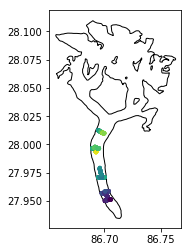

In [4]:
rgi = gpd.read_file('data/rgi/RGI60-15.03473.shp')
ax = rgi.plot(edgecolor='k', facecolor='w');
thick.plot(ax=ax, c=thick.thick, markersize=10);

## What does Global ITMIX say about this glacier?

### First, look at the composite 

In [5]:
f_composite = 'data/f19/composite/thickness_RGI60-15.03473.tif'
ds = xr.open_rasterio(f_composite)

In [6]:
grid = salem.GeoTiff(f_composite).grid
smap = salem.Map(grid, countries=False)
smap.set_shapefile(rgi)

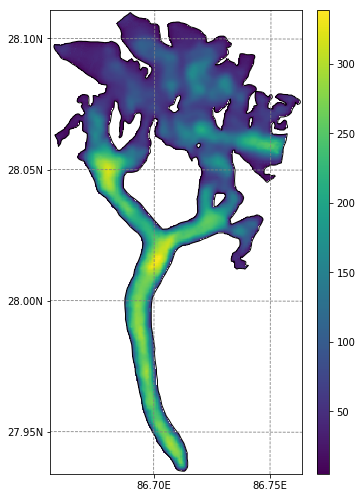

In [7]:
smap.set_data(ds.where(ds > 0))
f, ax = plt.subplots(1, 1, figsize=(5, 9))
smap.visualize(ax=ax);

In [8]:
df = pd.DataFrame(thick[['lon', 'lat', 'thick', 'alt']])
xx, yy = salem.transform_proj(salem.wgs84, grid.proj, df['lon'].values, df['lat'].values)
df['x'] = xx
df['y'] = yy
df['composite'] = ds.sel(band=1).interp(x=('z', df.x), y=('z', df.y))

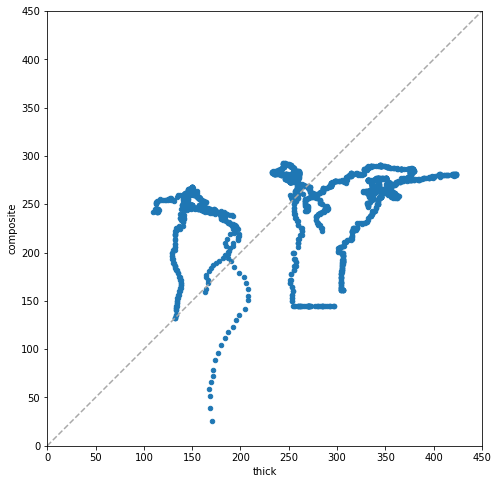

In [9]:
f, ax = plt.subplots(1, 1, figsize=(8, 8))
lims = [0, 450]
df.plot.scatter(ax=ax, x='thick', y='composite')
ax.plot(lims, lims, '--', color='darkgrey');
plt.xlim(lims); plt.ylim(lims);
ax.set_aspect(1.0)

## Now look at the individual models 

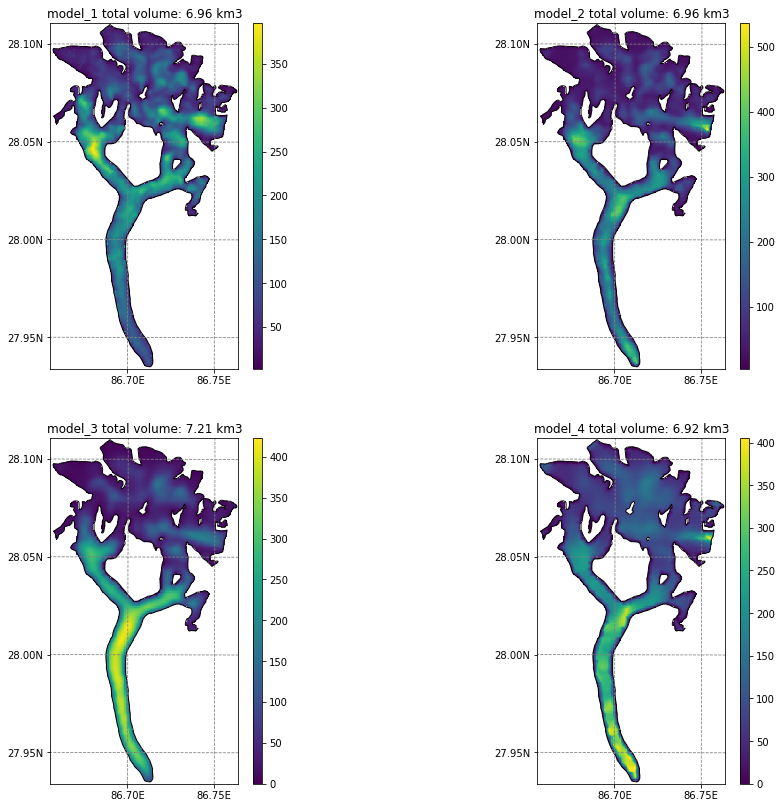

In [10]:
data_dir = 'data/f19/'
models = ['model_1', 'model_2', 'model_3', 'model_4']
f, axs = plt.subplots(2, 2, figsize=(16, 14))
axs = np.array(axs).flatten()
for ax, mod in zip(axs, models):
    f = data_dir + mod + '/thickness_RGI60-15.03473.tif'
    data = xr.open_rasterio(f)
    df[mod] = data.sel(band=1).interp(x=('z', df.x), y=('z', df.y))
    
    smap.set_data(data.where(ds > 1))
    smap.visualize(ax=ax)
    vol = data.sel(band=1).sum() * grid.dx**2 * 1e-9
    ax.set_title(mod + ' total volume: {:.2f} km3'.format(float(vol)))

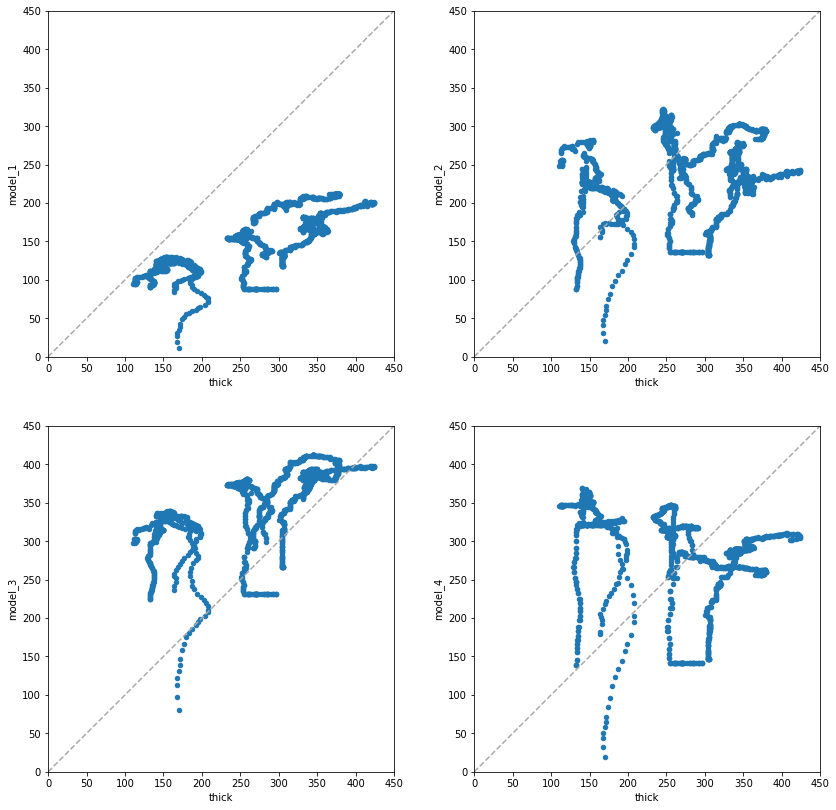

In [11]:
f, axs = plt.subplots(2, 2, figsize=(14, 14))
axs = np.array(axs).flatten()
lims = [0, 450]
for ax, mod in zip(axs, models):
    df.plot.scatter(ax=ax, x='thick', y=mod)
    ax.plot(lims, lims, '--', color='darkgrey');
    ax.set_xlim(lims); ax.set_ylim(lims);
    ax.set_aspect(1.0)

## Some scores and easy statistics 

In [12]:
df = df[['thick', 'composite'] + models]

In [13]:
df.describe()

,thick,composite,model_1,model_2,model_3,model_4
count,1858.000000,1858.000000,1858.000000,1858.000000,1858.000000,1858.000000
mean,272.126790,251.037302,152.549627,237.507128,349.777464,285.991658
std,80.211062,39.045382,35.464582,51.571966,48.730467,52.827279
min,109.911762,25.168567,11.500120,20.157297,80.413094,19.797904
25%,233.758531,244.483557,122.956219,214.687826,322.930597,266.630811
50%,279.532999,262.444496,156.267389,242.613276,368.805570,289.622671
75%,339.858814,276.939638,179.338861,276.333530,384.454747,320.168776
max,423.424678,292.410493,212.197630,322.045050,411.859303,369.434928


In [14]:
df.corr()

,thick,composite,model_1,model_2,model_3,model_4
thick,1.000000,0.344197,0.769160,0.210222,0.622823,-0.245969
composite,0.344197,1.000000,0.767013,0.923940,0.914237,0.742883
model_1,0.769160,0.767013,1.000000,0.649842,0.878960,0.191762
model_2,0.210222,0.923940,0.649842,1.000000,0.778862,0.651982
model_3,0.622823,0.914237,0.878960,0.778862,1.000000,0.484118
model_4,-0.245969,0.742883,0.191762,0.651982,0.484118,1.000000


In [15]:
sdf = pd.DataFrame()
for mod in ['composite'] + models:
    sdf.loc['RMSD', mod] = utils.rmsd(df.thick, df[mod])
    sdf.loc['MAD', mod] = utils.mad(df.thick, df[mod])
    sdf.loc['R2', mod] = utils.corrcoef(df.thick, df[mod])**2
    sdf.loc['BIAS', mod] = utils.md(df.thick, df[mod])
sdf

NameError: name 'utils' is not defined

In [ ]:
g = sns.PairGrid(df[['thick', 'composite'] + models])
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter);
g.set(xlim=lims, ylim=lims);

## Along transect stuff 

In [ ]:
rgi_proj = salem.transform_geopandas(rgi, to_crs=grid.proj)

In [ ]:
for trans_id in [1, 2, 3, 4]:
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))
    
    f = 'data/icethick/transects/transect_{}.shp'.format(trans_id)
    trans = gpd.read_file(f).rename(columns={'long_':'lon'})
    trans = salem.transform_geopandas(trans, to_crs=grid.proj)

    rgi_proj.plot(ax=ax1, edgecolor='k', facecolor='w');
    trans.plot(ax=ax1, markersize=10);

    left = trans.sort_values(by='min_x').iloc[0]
    trans['dis'] = np.sqrt((trans.min_x - left.min_x)**2 + (trans.min_y - left.min_y)**2)
    trans = trans.sort_values(by='dis')
    trans = trans.set_index('dis')

    df = pd.DataFrame(trans[['thick']])
    xx, yy = salem.transform_proj(salem.wgs84, grid.proj, trans['lon'].values, trans['lat'].values)
    df['x'] = xx
    df['y'] = yy

    ds = xr.open_rasterio(f_composite)
    df['composite'] = ds.sel(band=1).interp(x=('z', df.x), y=('z', df.y))

    for ax, mod in zip(axs, models):
        f = 'data/f19/{}/thickness_RGI60-15.03473.tif'.format(mod)
        ds = xr.open_rasterio(f)
        df[mod] = ds.sel(band=1).interp(x=('z', df.x), y=('z', df.y))

    df['thick'].plot(ax=ax2, linewidth=3, c='k')
    df[models].plot(ax=ax2);
    ax2.set_ylim(lims)